# Clustering 
1. Hierarchical clustering
2. K-means clustering
3. DBScanner clustering

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth #
from sklearn.neighbors import NearestNeighbors #
from sklearn.mixture import GaussianMixture #
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.spatial.distance import pdist, squareform


In [2]:
df = pd.read_csv('Processed_Data.csv')

In [3]:
df.head(5)

,vendor_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,...,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,engagement_duration,tot_value_cui,preferred_order_day,preferred_order_hour,age_category
0,2.0,1.0,0.0,1.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,28.88,0,18,26
1,2.0,2.0,0.0,1.0,12.82,6.39,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,19.21,0,10,16
2,1.0,2.0,0.0,1.0,9.20,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,9.20,0,9,42
3,2.0,1.0,0.0,2.0,0.00,13.70,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,31.56,1,11,26
4,2.0,0.0,0.0,2.0,14.57,40.87,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,55.44,1,8,26


In [4]:
cluster_features = ['vendor_count', 'is_chain', 'first_order', 'last_order', 
                                       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
                                       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 
                                       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 
                                       'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 
                                       'CUI_Thai', 'engagement_duration', 'tot_value_cui', 
                                       'preferred_order_day', 'preferred_order_hour', 
                                       'age_category']

print('cluster_features', cluster_features)

cluster_features ['vendor_count', 'is_chain', 'first_order', 'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'engagement_duration', 'tot_value_cui', 'preferred_order_day', 'preferred_order_hour', 'age_category']


In [5]:
print(df[cluster_features].dtypes)

vendor_count                float64
is_chain                    float64
first_order                 float64
last_order                  float64
CUI_American                float64
CUI_Asian                   float64
CUI_Beverages               float64
CUI_Cafe                    float64
CUI_Chicken Dishes          float64
CUI_Chinese                 float64
CUI_Desserts                float64
CUI_Healthy                 float64
CUI_Indian                  float64
CUI_Italian                 float64
CUI_Japanese                float64
CUI_Noodle Dishes           float64
CUI_OTHER                   float64
CUI_Street Food / Snacks    float64
CUI_Thai                    float64
engagement_duration           int64
tot_value_cui               float64
preferred_order_day           int64
preferred_order_hour          int64
age_category                  int64
dtype: object


With this we can confirm that all features features are numeric (`float64` and `int64`)

In [6]:
print(df.shape)  

(31875, 24)


In [7]:
print(cluster_features) 

['vendor_count', 'is_chain', 'first_order', 'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'engagement_duration', 'tot_value_cui', 'preferred_order_day', 'preferred_order_hour', 'age_category']


### Hierarchical Clustering 

Linkage Matrix

In [8]:
linkage_matrix = linkage(df[cluster_features].to_numpy(), method='ward')

Dendrogram

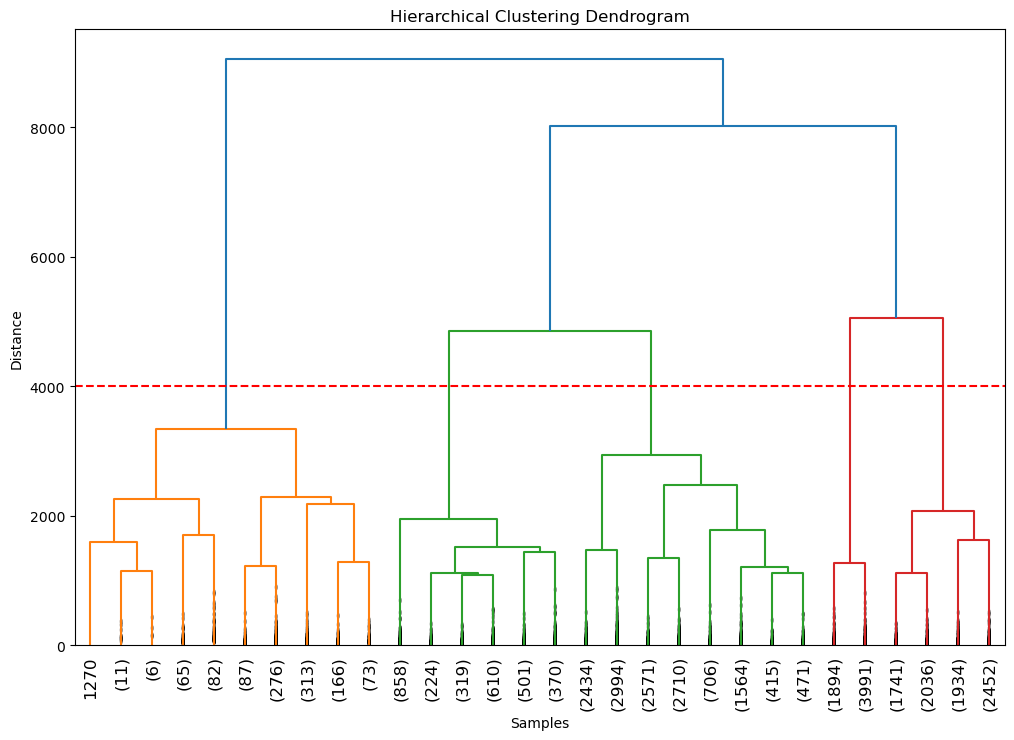

In [9]:
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  
    p=30, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True)

plt.axhline(y=4000, color='r', linestyle='--') 

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

Number of clusters

In [10]:
cluster_labels = fcluster(linkage_matrix, t=4000, criterion='distance')

In [11]:
df['Cluster'] = cluster_labels
print(df['Cluster'].value_counts())

Cluster
3    13865
5     8163
4     5885
2     2882
1     1080
Name: count, dtype: int64


##### 1. Dendrogram
The dendrogram was generated using the **Ward's Linkage** method, which minimizes the variation within clusters. 
- The red line represents the **cut-off height** defined at `t=4000`.
- This line determines the number of clusters by "cutting" the dendrogram.
- The branches below the red line correspond to the formed clusters.

##### 2. Clusters
**5 clusters** were identified, with the following sizes:

| Cluster | Number of Samples |
|---------|--------------------|
| 1       | 1080                |
| 2       | 2882             |
| 3       | 13865             |
| 4       | 5885             |
| 5       | 8163             |


### Cluster Analysis: 
The following variables were analyzed across clusters:
- `vendor_count`
- `is_chain`
- `first_order`
- `last_order`
- `engagement_duration`
- `tot_value_cui`
- `preferred_order_day`
- `preferred_order_hour`
- `age_category`

This analysis focuses on identifying patterns and differences in these variables among the clusters.

In [19]:
other_columns = [
    'vendor_count', 'is_chain', 'first_order', 'last_order',
    'engagement_duration', 'tot_value_cui', 
    'preferred_order_day', 'preferred_order_hour', 'age_category' ]

other_analysis = cluster_analysis[other_columns]
print("Analysis of Other Variables by Cluster:")
print(other_analysis)

Analysis of Other Variables by Cluster:
         vendor_count  is_chain  first_order  last_order  engagement_duration  \
Cluster                                                                         
1            9.006481  9.367593     9.528704   82.296296            72.767593   
2            5.915337  5.749480    12.465649   80.564192            68.098543   
3            3.542806  3.325279    19.789903   72.539776            52.749874   
4            1.660153  1.165166    66.836364   74.950552             8.114189   
5            1.618890  1.251746    23.340071   32.052309             8.712238   

         tot_value_cui  preferred_order_day  preferred_order_hour  \
Cluster                                                             
1           210.046037             2.725926             10.559259   
2            96.535448             2.625607             10.096114   
3            34.476383             2.536819             11.528597   
4            18.008479             2.790654    

The following cuisine-related variables were analyzed across clusters:
- `CUI_American`
- `CUI_Asian`
- `CUI_Beverages`
- `CUI_Cafe`
- `CUI_Chicken Dishes`
- `CUI_Chinese`
- `CUI_Healthy`
- `CUI_Indian`
- `CUI_Italian`
- `CUI_Japanese`
- `CUI_Noodle Dishes`
- `CUI_OTHER`
- `CUI_Street Food / Snacks`
- `CUI_Thai`

In [18]:
cuisine_columns = [
    'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
    'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 
    'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 
    'CUI_Thai']

cuisine_analysis = cluster_analysis[cuisine_columns]
print("Cuisine Analysis by Cluster:")
print(cuisine_analysis)

Cuisine Analysis by Cluster:
         CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
Cluster                                                                         
1           20.462611  66.895481       5.814741  7.886620            1.555028   
2           12.822776  29.749080       5.977228  1.678796            0.945066   
3            4.596865   7.584333       2.291559  0.625016            1.074080   
4            2.158909   3.773947       1.254257  0.317162            0.347636   
5            2.445832   3.917059       1.298034  0.203271            0.386130   

         CUI_Chinese  CUI_Healthy  CUI_Indian  CUI_Italian  CUI_Japanese  \
Cluster                                                                    
1           7.873620     3.312620    7.484769    15.633759     12.891333   
2           2.151461     3.116707    1.660892     7.499025      8.779473   
3           1.601034     0.807835    1.897088     3.076501      2.495436   
4           0.503801   

# Cluster Analysis Summary

| **Cluster** | **Vendor Count** | **Is Chain** | **First Order** | **Last Order** | **Engagement Duration** | **Total Value** | **Preferred Order Day** | **Preferred Order Hour** | **Age Category** | **Top Cuisines**                | **Conclusion**                                                                 |
|-------------|------------------|--------------|------------------|----------------|--------------------------|-----------------|--------------------------|--------------------------|------------------|----------------------------------|--------------------------------------------------------------------------------|
| **1**       | 9.01             | 9.37         | 9.53             | 82.30          | 72.77                   | 210.05          | 2.73                     | 10.56                    | 29.12           | Asian, American, Snacks         | High-spending, loyal customers, mostly aged around 29 years, with high engagement, preferring Asian cuisine, snacks, and morning orders. |
| **2**       | 5.91             | 5.74         | 12.46            | 80.56          | 68.10                   | 96.54           | 2.63                     | 10.10                    | 28.87           | Asian, American                 | Moderately spending customers, aged around 28 years, with steady engagement, preferring Asian and American cuisines and morning orders. |
| **3**       | 3.54             | 3.32         | 19.79            | 72.54          | 52.75                   | 34.48           | 2.54                     | 11.53                    | 28.54           | Asian, American                 | Low-spending, moderately engaged customers, aged around 28 years, with delayed first orders, preferring Asian cuisine and mid-morning orders. |
| **4**       | 1.66             | 1.16         | 66.83            | 74.95          | 8.11                    | 18.01           | 2.79                     | 11.71                    | 29.19           | Asian, American                 | Inactive customers, mostly aged around 29 years, with very low spending and engagement, preferring occasional Asian cuisine and late-morning orders. |
| **5**       | 1.62             | 1.25         | 23.34            | 32.05          | 8.71                    | 16.12           | 2.83                     | 11.87                    | 28.62           | Asian, American                 | New or disengaged customers, aged around 28 years, with minimal spending and low engagement, preferring Asian cuisine and late-morning orders. |



### 2. K-Means ###

### 3. DBSCAN (Density-based spatial clustering of applications with noise)
### Testeeeeeee

In [13]:
# Splitting feature names into groups
# Remember which metric_features we decided to keep?
metric_features = df.select_dtypes(include=['number']).columns.tolist()

# Identify non-metric (categorical) features
non_metric_features = df.select_dtypes(exclude=['number']).columns.tolist()
pc_features = df.columns[df.columns.str.startswith('PC')].tolist()  

unused_features = [i for i in df.columns if i not in (metric_features+non_metric_features+pc_features) ]

In [14]:
print('metric_features:', metric_features)
print('\nnon_metric_features:', non_metric_features)
print('\nunused_features:', unused_features)
print('\npc_features:', pc_features)

metric_features: ['vendor_count', 'is_chain', 'first_order', 'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'engagement_duration', 'tot_value_cui', 'preferred_order_day', 'preferred_order_hour', 'age_category', 'Cluster']

non_metric_features: []

unused_features: []

pc_features: []


In [15]:
# Display only columns with missing values
missing_values_all = df.isnull().sum()
missing_values = missing_values_all[missing_values_all > 0]

# Display the columns with missing values
print(missing_values)

Series([], dtype: int64)


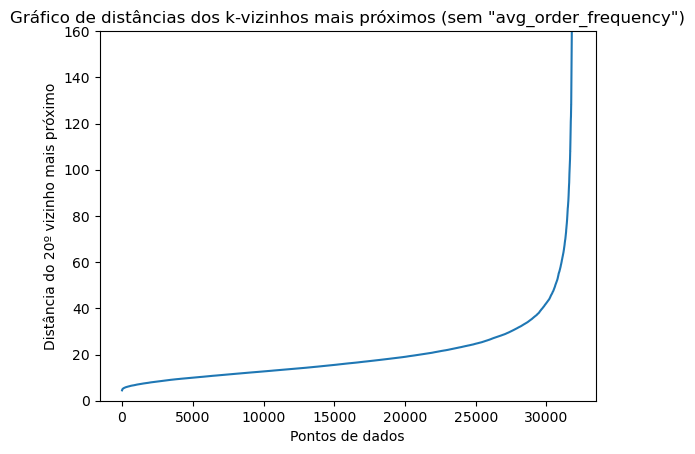

In [16]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Excluir a feature "avg_order_frequency" das metric features
features_for_distance = [feature for feature in metric_features if feature != "avg_order_frequency"]

# Calcular as distâncias dos k-vizinhos mais próximos
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df[features_for_distance])
distances, _ = neigh.kneighbors(df[features_for_distance])

# Ordenar as distâncias
distances = np.sort(distances[:, -1])

# Plotar o gráfico das distâncias
plt.plot(distances)
plt.xlabel('Pontos de dados')
plt.ylabel('Distância do 20º vizinho mais próximo')
plt.title('Gráfico de distâncias dos k-vizinhos mais próximos (sem "avg_order_frequency")')

# Alterar os limites do eixo y para 0 a 160
plt.ylim(0, 160)

plt.show()


In [17]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

NameError: name 'dbscan_labels' is not defined

In [88]:
# Excluir a feature "total_value_cui" ao selecionar as features para o clustering
features_for_clustering = [feature for feature in metric_features if feature != "avg_order_frequency"]

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=40, min_samples=25, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[features_for_clustering])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

#usei o eps=40 por causa do grafico
#usei min_samples=25 porque deve ser 2xdim e deve ser mais ou menos isso


Number of estimated clusters : 8


In [89]:
np.unique(dbscan_labels)


array([-1,  0,  1,  2,  3,  4,  5,  6])